In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np

# pd.datetime is an alias for datetime.datetime
today = pd.datetime.today()
lbd = (today - BDay(1)).date()
url = 'https://www.quandl.com/api/v3/databases/EOD/metadata?#api_key=5czsVZzyn5zaXksb31tF'
tickers = pd.read_csv(url,engine='python', compression='zip')
df = tickers.loc[tickers['to_date'] == str(lbd)].reset_index(drop=True)
df.head()

,code,name,description,refreshed_at,from_date,to_date
0,A,"Agilent Technologies Inc. (A) Stock Prices, Di...",<p><b>Ticker</b>: A</p> <p><b>Exchange</b>: NY...,2019-07-17 00:52:39,1999-11-18,2019-07-16
1,AA,"Alcoa Corporation (AA) Stock Prices, Dividends...",<p><b>Ticker</b>: AA</p> <p><b>Exchange</b>: N...,2019-07-17 00:52:59,2016-11-01,2019-07-16
2,AAAU,"Perth Mint Physical Gold (AAAU) Stock Prices, ...",<p><b>Ticker</b>: AAAU</p> <p><b>Exchange</b>:...,2019-07-17 00:53:19,2018-08-15,2019-07-16
3,AABA,"Altaba Inc. (AABA) Stock Prices, Dividends and...",<p><b>Ticker</b>: AABA</p> <p><b>Exchange</b>:...,2019-07-17 00:52:39,1996-04-12,2019-07-16
4,AAC,"AAC Holdings Inc. (AAC) Stock Prices, Dividend...",<p><b>Ticker</b>: AAC</p> <p><b>Exchange</b>: ...,2019-07-17 00:52:52,2014-10-02,2019-07-16


# Get Daily

In [2]:
from alpha_vantage.timeseries import TimeSeries
key = 'BJUEJ3R9ZM8ER5KY'
ts = TimeSeries(key=key, output_format='pandas')

In [25]:
for i in np.arange(10):
    try:
        data, meta_data = ts.get_daily(symbol='A', outputsize='full')
        break
    except:
        print('Attempt # {} failed'.format(str(i)))

In [26]:
print(meta_data)
data.head()

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'A', '3. Last Refreshed': '2019-07-17 13:58:19', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
1999-11-18,45.50,50.00,40.00,44.00,44739900.0
1999-11-19,42.94,43.00,39.81,40.38,10897100.0
1999-11-22,41.31,44.00,40.06,44.00,4705200.0
1999-11-23,42.50,43.63,40.25,40.25,4274400.0
1999-11-24,40.13,41.94,40.00,41.06,3464400.0


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

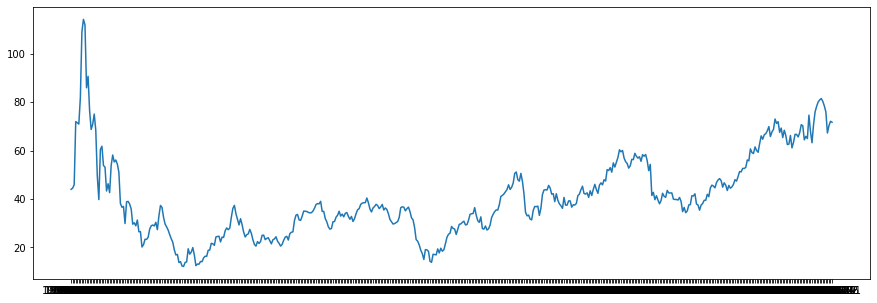

In [28]:
plt.plot(data['4. close'][0::10])
plt.show()

In [29]:
data.index

Index(['1999-11-18', '1999-11-19', '1999-11-22', '1999-11-23', '1999-11-24',
       '1999-11-26', '1999-11-29', '1999-11-30', '1999-12-01', '1999-12-02',
       ...
       '2019-07-03', '2019-07-05', '2019-07-08', '2019-07-09', '2019-07-10',
       '2019-07-11', '2019-07-12', '2019-07-15', '2019-07-16', '2019-07-17'],
      dtype='object', name='date', length=4945)

In [30]:
date_split = '2016-01-01'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(4055, 890)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = data[len(data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [ ]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [ ]:
inputs.shape[0]

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
#for plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

valid = data.tail(896)
valid['Predictions'] = closing_price
plt.plot(valid[['close','Predictions']])

In [ ]:
valid['close_dif'] = valid['close'].diff()
valid['pred_dif'] = valid['Predictions'].diff()
valid.head()

In [ ]:
valid['type'] = 0
k = valid.loc[(valid['close_dif']>0) & (valid['pred_dif']>0)].index
valid.at[k,'type'] = 1
k = valid.loc[(valid['close_dif']<0) & (valid['pred_dif']<0)].index
valid.at[k,'type'] = 1

In [ ]:
valid.head()

In [ ]:
valid['type'].sum()/valid.shape[0]

In [ ]:
train = data.iloc[0:4000]
valid = data.iloc[4001:]

In [ ]:
data['4. close']

In [ ]:
data

In [ ]:
from bs4 import BeautifulSoup
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [ ]:
driver = webdriver.Chrome()

In [ ]:
url = 'https://www.netfonds.no/quotes/exchange.php?exchange=O'
browser = webdriver.Chrome()

In [ ]:
soup = BeautifulSoup(website_url,'lxml')

In [ ]:
My_table = soup.find('table',{'class':'com'})

In [ ]:
My_table

In [ ]:
ti = My_table.findAll('tr')
ti

In [ ]:
import pandas as pd
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay

# pd.datetime is an alias for datetime.datetime
today = pd.datetime.today()
lbd = (today - BDay(1)).date()

In [ ]:
df = tickers.loc[tickers['to_date'] == str(lbd)].reset_index(drop=True)
temp = df.head(100)

In [ ]:
yf = YahooFinancials('ABBV')
yf.get_prev_close_price()

In [ ]:
temp.iloc[21]['closing']

In [ ]:
from yahoofinancials import YahooFinancials
from multiprocessing import Pool

t = temp['code']

def f(x):
    yf = YahooFinancials(x)
    return yf.get_prev_close_price()

if __name__ == '__main__':
    with Pool(8) as p:
        closing = p.map(f, t)

temp['closing'] = closing
print('done')

In [ ]:
maxprice = 20
df = temp.loc[temp['closing']<maxprice].reset_index(drop=True)

In [ ]:
df

In [ ]:
import requests
import io
import pandas as pd
import quandl
from datetime import datetime, date,  timedelta

In [ ]:
from yahoofinancials import YahooFinancials
import pandas as pd

In [ ]:
from yahoofinancials import YahooFinancials

ticker = ['AAPL', 'AA']
test = YahooFinancials(ticker)

In [ ]:
d = test.get_historical_price_data('2019-01-01','2019-01-31', 'daily')

In [ ]:
for i in d.keys():
    print(pd.DataFrame(d[i]['prices']))
    break

In [ ]:
d['AA']

In [ ]:
pd.DataFrame.from_dict(d,orient='index')

In [ ]:
def dater(x):
    try:
        return datetime.strptime(x, '%Y-%m-%d').date() 
    except:
        return None

In [ ]:
backup = tickers.copy()

In [ ]:
tickers = backup.copy()

In [ ]:
yesterday = datetime.today().date()-timedelta(1)
tickers['from_date'] = [dater(x) for x in tickers['from_date']]
tickers['to_date'] = [dater(x) for x in tickers['to_date']]
k = [x == yesterday for x in tickers['to_date']]
tickers = tickers.iloc[k].reset_index(drop=True)
tickers.head()

In [ ]:
tickers.shape

In [ ]:
[x[44:53] for x in tickers['description']]

In [ ]:
tickers['description'][0]

In [ ]:
datetime.datetime.strptime(tickers['from_date'][0], '%Y-%m-%d').date()